## Reshape des inputs

Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import time

Chargement des données

In [2]:
data = pd.read_pickle(r"C:\Users\quent\Documents\IMTA3\PO\V2\Inputs\group90min_inputs.pkl")

Paramètres pour le reshape des inputs

In [27]:
# Paramètre : Regroupement des données pour les input
## A indicer sur les données en sortie de input generation
step_group = "90min"

## A ajuster

# Paramètre : Intervalle de temps pour une ligne d'entrainement
delta_train = "6h"

# Paramètre : intervalle de temps sur lequel on souhaite faire une prédiction à une date donnée
delta_prediction = "90min"

# Paramètre : temps de window slide pour chaque nouvelle inpute
window_slide = "90min"

Indices pour sélection les lignes

In [28]:
index_delta_train = pd.Timedelta(delta_train).seconds // pd.Timedelta(step_group).seconds
index_delta_prediction = pd.Timedelta(delta_prediction).seconds // pd.Timedelta(step_group).seconds
index_window_slide = pd.Timedelta(window_slide).seconds // pd.Timedelta(step_group).seconds

Initialisation des listes vide

In [29]:
X = list()
y = list()

Ajout des variables d'entrainement dans ces listes

In [30]:
start = time.time()

index = 0

while (index + index_delta_train < data.shape[0]) and (index+index_delta_prediction < data.shape[0]):
    index_end = index+index_delta_train
    X.append(list(data.iloc[index:index_end].values))
    y.append(list(data.iloc[index_end:index_end+index_delta_prediction, 1:-(7+12)].sum().values))
    index += index_window_slide
    
print("Temps d'exécution : {:.2} s".format(time.time()-start))

Temps d'exécution : 7.0 s


On passe les variables au format numpy array

In [31]:
X = np.array(X)
y = np.array(y)

Séparation des données entre le training set (90%) et le test set (10%)

In [32]:
# Test set
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

date_test = X_test[:,:,0].flatten()
X_test = np.delete(X_test, 0, axis=2)


# Train and dev set
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, random_state=1)

date_train = X_train[:,:,0].flatten()
X_train = np.delete(X_train, 0, axis=2)

date_val = X_val[:,:,0].flatten()
X_val = np.delete(X_val, 0, axis=2)

In [33]:
X_train.shape

(4451, 4, 276)

In [34]:
X1_train = X_train[:,:,:259]
X2_train = X_train[:,-1,259:]

X1_val = X_val[:,:,:259]
X2_val = X_val[:,-1,259:]

print(X1_train.shape)
print(X2_train.shape)

(4451, 4, 259)
(4451, 17)


## Model

Import des librairies

In [35]:
from datetime import datetime

Données d'architecture du LSTM

In [36]:
nb_inputs = X_train.shape[0]
nb_steps = X_train.shape[1]
nb_features = X_train.shape[2]

nb_inputs

4451

## Keras

In [40]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input, Concatenate, Dropout
from keras.layers import Dense
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.models import Model
import keras.backend as K
import tensorflow as tf
import keras

from livelossplot import PlotLossesKeras

In [47]:
nb_steps = X_train.shape[1]
nb_features = X_train.shape[2]
nb_hidden_units = 250
batch_size = 256

out_shape = y_train.shape[1]

In [48]:
#Nos deux set d'entrés 
inputA = Input(shape=(X1_train.shape[1],X1_train.shape[2]))
inputB = Input(shape=(X2_train.shape[1],))

#Le modèle qui va gérer les premieres inputs
x = Dropout(0.2)(inputA)
x = LSTM(nb_hidden_units, activation='relu')(x)
x = Dense(out_shape, activation='relu')(x)
x = Model(inputs=inputA, outputs=x)

#Le modèle qui va gérer les deuxièmes inputs 
y = Dense(2, activation='relu')(inputB)
y = Model(inputs=inputB,outputs=y)

#On combine les deux résultats
combined = Concatenate()([x.output,y.output])

z = Dense(out_shape, activation='relu')(combined)

model = Model(inputs=[x.input, y.input], outputs=z)

In [49]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

model.summary()

# Load pre trained weights
#model.load_weights('/tmp/weights.hdf5')

history = model.fit([X1_train,X2_train], y_train, validation_data=([X1_val,X2_val], y_val), epochs=100, verbose=1)

print("\n")
print("Time : {:.2f} s".format(time.time()-start))

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 4, 259)       0                                            
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 4, 259)       0           input_11[0][0]                   
__________________________________________________________________________________________________
lstm_6 (LSTM)                   (None, 250)          510000      dropout_3[0][0]                  
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 17)           0                                            
___________________________________________________________________________________________

Epoch 41/100
4451/4451 [==============================] - 3s 735us/step - loss: 34.0526 - accuracy: 0.5325 - val_loss: 50.2281 - val_accuracy: 0.3939
Epoch 42/100
4451/4451 [==============================] - 3s 730us/step - loss: 33.1199 - accuracy: 0.5340 - val_loss: 48.9572 - val_accuracy: 0.4263
Epoch 43/100
4451/4451 [==============================] - 3s 739us/step - loss: 32.7277 - accuracy: 0.5397 - val_loss: 49.7726 - val_accuracy: 0.4182
Epoch 44/100
4451/4451 [==============================] - 3s 732us/step - loss: 32.4199 - accuracy: 0.5401 - val_loss: 49.3166 - val_accuracy: 0.4242
Epoch 45/100
4451/4451 [==============================] - 3s 755us/step - loss: 32.0384 - accuracy: 0.5424 - val_loss: 49.7487 - val_accuracy: 0.4404
Epoch 46/100
4451/4451 [==============================] - 3s 738us/step - loss: 31.6289 - accuracy: 0.5471 - val_loss: 48.6185 - val_accuracy: 0.4222
Epoch 47/100
4451/4451 [==============================] - 3s 735us/step - loss: 31.8931 - accuracy: 

4451/4451 [==============================] - 3s 739us/step - loss: 23.7000 - accuracy: 0.6073 - val_loss: 50.3367 - val_accuracy: 0.4323
Epoch 96/100
4451/4451 [==============================] - 3s 738us/step - loss: 23.5900 - accuracy: 0.6185 - val_loss: 49.0788 - val_accuracy: 0.4404
Epoch 97/100
4451/4451 [==============================] - 3s 727us/step - loss: 23.6230 - accuracy: 0.6201 - val_loss: 49.6885 - val_accuracy: 0.4121
Epoch 98/100
4451/4451 [==============================] - 3s 730us/step - loss: 23.4803 - accuracy: 0.6100 - val_loss: 49.2198 - val_accuracy: 0.4303
Epoch 99/100
4451/4451 [==============================] - 3s 752us/step - loss: 23.1350 - accuracy: 0.6046 - val_loss: 49.8605 - val_accuracy: 0.4141
Epoch 100/100
4451/4451 [==============================] - 4s 838us/step - loss: 23.4030 - accuracy: 0.6073 - val_loss: 48.9378 - val_accuracy: 0.4202


Time : 1138.00 s


Sauvegarde des poids

In [ ]:
model.save_weights(filepath="weights/inputs_{}_DT_{}_DP_{}_WS_{}_hidden_{}.hdf5".format(step_group,delta_train,delta_prediction,window_slide,nb_hidden_units))

Tensorboard

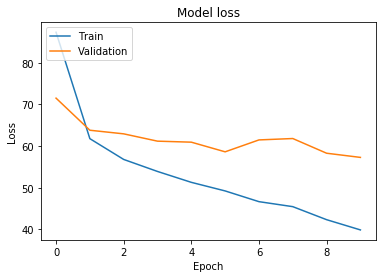

In [45]:

import matplotlib.pyplot as plt
# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

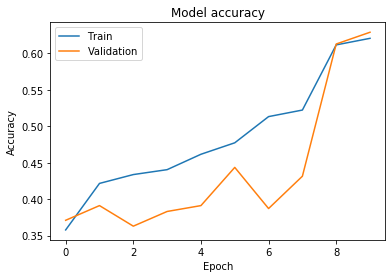

In [46]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Validate on test set